In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import sklearn
import lightgbm as lgb
import optuna
import streamlit as st
import plotly
import joblib
import sys

file_path = r'E:\airta drafts\PREDIKSI KADAR HB\data\raw\erm_hd.xlsx'

try:
    df = pd.read_excel(file_path)
    display(df.head())

    print("\n Informasi Dataset:")
    df.info()

except Exception as e:
    print(f"Terjadi kesalahan: {e}")

,id_pasien,jenis_kelamin,tgl_lahir,tgl_pemeriksaan,eritrosit,hematokrit,MCHC,MCH,MCV,hemoglobin,leukosit,trombosit,status_epo
0,1,P,1965-07-04,2025-03-01,2.8,25.4,33.9,30.2,89.4,8.6,7830,309000,TIDAK
1,1,P,1965-07-04,2025-04-02,2.7,24.3,33.3,29.7,88.9,8.1,7150,262000,TIDAK
2,1,P,1965-07-04,2025-05-03,2.8,24.5,33.9,29.8,88.4,8.3,8070,297000,TIDAK
3,1,P,1965-07-04,2025-06-04,2.7,24.0,32.9,29.2,88.6,7.9,7960,291000,TIDAK
4,1,P,1965-07-04,2025-07-02,2.5,22.5,33.3,29.7,89.5,7.5,7860,307000,TIDAK



 Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id_pasien        829 non-null    int64  
 1   jenis_kelamin    829 non-null    object 
 2   tgl_lahir        829 non-null    object 
 3   tgl_pemeriksaan  829 non-null    object 
 4   eritrosit        829 non-null    object 
 5   hematokrit       829 non-null    object 
 6   MCHC             829 non-null    object 
 7   MCH              829 non-null    object 
 8   MCV              829 non-null    object 
 9   hemoglobin       829 non-null    float64
 10  leukosit         828 non-null    object 
 11  trombosit        828 non-null    object 
 12  status_epo       829 non-null    object 
dtypes: float64(1), int64(1), object(11)
memory usage: 84.3+ KB


In [2]:
df_clean = df.copy()

#1. KONVERSI DATATYPE
cols_numeric = ['eritrosit', 'hematokrit', 'MCHC', 'MCH', 'MCV', 'hemoglobin', 'leukosit', 'trombosit']

for col in cols_numeric:
    df_clean[col] = pd.to_numeric(df_clean[col].astype(str).str.strip().str.replace(',', '.'), errors='coerce')

df_clean['tgl_lahir'] = pd.to_datetime(df_clean['tgl_lahir'], errors='coerce')
df_clean['tgl_pemeriksaan'] = pd.to_datetime(df_clean['tgl_pemeriksaan'], errors='coerce')

#Hitung selisih tahun
df_clean['usia'] = ((df_clean['tgl_pemeriksaan'] - df_clean['tgl_lahir']).dt.days / 365.25).fillna(0).astype(int)

cols = df_clean.columns.tolist()
idx = cols.index('tgl_lahir')
cols.insert(idx + 1, cols.pop(cols.index('usia')))
df_clean = df_clean[cols]

#2. HANDLING MISSING VALUES (RATA-RATA PER FITUR)
for col in cols_numeric:
    rata_rata = df_clean[col].mean()
    df_clean[col] = df_clean[col].fillna(rata_rata)



cols_int = ['leukosit', 'trombosit']
for col in cols_int:
    df_clean[col] = df_clean[col].round().astype('Int64')


#3. BINERISASI STATUS EPO
mapping_epo = {'TIDAK': 0, 'YA': 1}
df_clean['epo'] = df_clean['status_epo'].map(mapping_epo)

cols = df_clean.columns.tolist()
idx_epo = cols.index('status_epo')
cols.insert(idx_epo + 1, cols.pop(cols.index('epo')))
df_clean = df_clean[cols]

#4. BINERISASI JENIS KELAMIN
mapping_jk = {'P': 0, 'L': 1}
df_clean['jk'] = df_clean['jenis_kelamin'].map(mapping_jk)

cols = df_clean.columns.tolist()
idx_jk = cols.index('jenis_kelamin')
cols.insert(idx_jk + 1, cols.pop(cols.index('jk')))
df_clean = df_clean[cols]

In [3]:
df_clean.info()

print("Cuplikan 12 Baris Pertama Dataset Raw:")
display(df.head(12))

print("Cuplikan 12 Baris Pertama Dataset Clean:")
display(df_clean.head(12))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id_pasien        829 non-null    int64         
 1   jenis_kelamin    829 non-null    object        
 2   jk               829 non-null    int64         
 3   tgl_lahir        829 non-null    datetime64[ns]
 4   usia             829 non-null    int64         
 5   tgl_pemeriksaan  829 non-null    datetime64[ns]
 6   eritrosit        829 non-null    float64       
 7   hematokrit       829 non-null    float64       
 8   MCHC             829 non-null    float64       
 9   MCH              829 non-null    float64       
 10  MCV              829 non-null    float64       
 11  hemoglobin       829 non-null    float64       
 12  leukosit         829 non-null    Int64         
 13  trombosit        829 non-null    Int64         
 14  status_epo       829 non-null    object   

,id_pasien,jenis_kelamin,tgl_lahir,tgl_pemeriksaan,eritrosit,hematokrit,MCHC,MCH,MCV,hemoglobin,leukosit,trombosit,status_epo
0,1,P,1965-07-04,2025-03-01,2.8,25.4,33.9,30.2,89.4,8.6,7830,309000,TIDAK
1,1,P,1965-07-04,2025-04-02,2.7,24.3,33.3,29.7,88.9,8.1,7150,262000,TIDAK
2,1,P,1965-07-04,2025-05-03,2.8,24.5,33.9,29.8,88.4,8.3,8070,297000,TIDAK
3,1,P,1965-07-04,2025-06-04,2.7,24.0,32.9,29.2,88.6,7.9,7960,291000,TIDAK
4,1,P,1965-07-04,2025-07-02,2.5,22.5,33.3,29.7,89.5,7.5,7860,307000,TIDAK
5,1,P,1965-07-04,2025-08-02,2.7,24.2,32.6,29.5,89.7,7.9,9600,315000,TIDAK
6,1,P,1965-07-04,2025-08-23,2.9,25.2,32.1,28.6,88.4,7.9,9510,352000,TIDAK
7,1,P,1965-07-04,2025-09-03,3.3,29.3,32.4,28.4,87.6,9.5,8710,343000,TIDAK
8,1,P,1965-07-04,2025-10-01,3.2,28.0,32.9,28.6,87.2,9.1,9860,269000,TIDAK
9,1,P,1965-07-04,2025-11-01,3.1,27.0,32.2,28.3,88.1,8.7,10140,285000,TIDAK


Cuplikan 12 Baris Pertama Dataset Clean:


,id_pasien,jenis_kelamin,jk,tgl_lahir,usia,tgl_pemeriksaan,eritrosit,hematokrit,MCHC,MCH,MCV,hemoglobin,leukosit,trombosit,status_epo,epo
0,1,P,0,1965-07-04,59,2025-03-01,2.8,25.4,33.900000,30.200000,89.400000,8.6,7830,309000,TIDAK,0
1,1,P,0,1965-07-04,59,2025-04-02,2.7,24.3,33.300000,29.700000,88.900000,8.1,7150,262000,TIDAK,0
2,1,P,0,1965-07-04,59,2025-05-03,2.8,24.5,33.900000,29.800000,88.400000,8.3,8070,297000,TIDAK,0
3,1,P,0,1965-07-04,59,2025-06-04,2.7,24.0,32.900000,29.200000,88.600000,7.9,7960,291000,TIDAK,0
4,1,P,0,1965-07-04,59,2025-07-02,2.5,22.5,33.300000,29.700000,89.500000,7.5,7860,307000,TIDAK,0
5,1,P,0,1965-07-04,60,2025-08-02,2.7,24.2,32.600000,29.500000,89.700000,7.9,9600,315000,TIDAK,0
6,1,P,0,1965-07-04,60,2025-08-23,2.9,25.2,32.100000,28.600000,88.400000,7.9,9510,352000,TIDAK,0
7,1,P,0,1965-07-04,60,2025-09-03,3.3,29.3,32.400000,28.400000,87.600000,9.5,8710,343000,TIDAK,0
8,1,P,0,1965-07-04,60,2025-10-01,3.2,28.0,32.900000,28.600000,87.200000,9.1,9860,269000,TIDAK,0
9,1,P,0,1965-07-04,60,2025-11-01,3.1,27.0,32.200000,28.300000,88.100000,8.7,10140,285000,TIDAK,0


In [4]:
df_clean = df_clean.drop(columns=['tgl_lahir', 'status_epo', 'jenis_kelamin'])
print(f"Kolom saat ini: {df_clean.columns.tolist()}")

Kolom saat ini: ['id_pasien', 'jk', 'usia', 'tgl_pemeriksaan', 'eritrosit', 'hematokrit', 'MCHC', 'MCH', 'MCV', 'hemoglobin', 'leukosit', 'trombosit', 'epo']


In [5]:
#5. AGGREGATION PER BULAN
df_clean['tgl_pemeriksaan'] = pd.to_datetime(df_clean['tgl_pemeriksaan'])

cols_to_mean = ['usia', 'jk', 'eritrosit', 'hematokrit', 'MCHC', 'MCH', 'MCV', 
                'hemoglobin', 'leukosit', 'trombosit', 'epo']

df_clean = (df_clean.groupby('id_pasien')
            .resample('MS', on='tgl_pemeriksaan')[cols_to_mean]
            .mean()
            .dropna()
            .reset_index())

cols_to_int = ['usia', 'jk', 'leukosit', 'trombosit', 'epo']
for col in cols_to_int:
    df_clean[col] = df_clean[col].round().astype('Int64')


print(f"Data berhasil diringkas per bulan.")

Data berhasil diringkas per bulan.


In [6]:
df_clean.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628 entries, 0 to 627
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id_pasien        628 non-null    int64         
 1   tgl_pemeriksaan  628 non-null    datetime64[ns]
 2   usia             628 non-null    Int64         
 3   jk               628 non-null    Int64         
 4   eritrosit        628 non-null    float64       
 5   hematokrit       628 non-null    float64       
 6   MCHC             628 non-null    float64       
 7   MCH              628 non-null    float64       
 8   MCV              628 non-null    float64       
 9   hemoglobin       628 non-null    float64       
 10  leukosit         628 non-null    Int64         
 11  trombosit        628 non-null    Int64         
 12  epo              628 non-null    Int64         
dtypes: Int64(5), datetime64[ns](1), float64(6), int64(1)
memory usage: 67.0 KB


In [7]:
counts = df_clean.groupby('id_pasien').size()

ids_to_check = counts[(counts >= 1) & (counts <= 3)].index

pasien_minim_data = df_clean[df_clean['id_pasien'].isin(ids_to_check)]

print(f"Jumlah pasien dengan data 1-3 baris: {len(ids_to_check)}")
print(pasien_minim_data)

Jumlah pasien dengan data 1-3 baris: 9
     id_pasien tgl_pemeriksaan  usia  jk  eritrosit  hematokrit       MCHC  \
66           8      2025-03-01    64   0   3.900000   36.200000  31.800000   
71          10      2025-03-01    54   0   3.500000   28.900000  31.100000   
72          10      2025-05-01    54   0   3.100000   24.900000  32.200000   
73          10      2025-06-01    54   0   3.000000   24.200000  31.400000   
438         48      2025-02-01    57   0   3.200000   26.900000  33.195934   
439         48      2025-03-01    57   0   3.100000   25.900000  33.600000   
440         48      2025-04-01    57   0   3.900000   33.200000  32.800000   
502         55      2025-03-01    54   0   3.500000   28.900000  31.100000   
503         55      2025-05-01    54   0   3.100000   24.900000  32.200000   
504         55      2025-06-01    54   0   3.000000   24.200000  31.400000   
533         60      2025-03-01    57   1   2.300000   20.600000  33.500000   
534         60      2025-

In [8]:
df_clean = df_clean.sort_values(['id_pasien', 'tgl_pemeriksaan'])

df_clean['periode_bulan'] = df_clean['tgl_pemeriksaan'].dt.to_period('M')

df_clean['gap_bulan'] = df_clean.groupby('id_pasien')['periode_bulan'].diff().apply(lambda x: x.n if pd.notnull(x) else 0)

pasien_loncat = df_clean[df_clean['gap_bulan'] > 1]

print("Deteksi Loncatan Bulan (Metode Kalender):")
if not pasien_loncat.empty:
    display(pasien_loncat[['id_pasien', 'tgl_pemeriksaan', 'gap_bulan']])
    print(f"\nTotal ditemukan {len(pasien_loncat)} kejadian loncat bulan.")
else:
    print("Tidak ditemukan data yang loncat bulannya.")

Deteksi Loncatan Bulan (Metode Kalender):


,id_pasien,tgl_pemeriksaan,gap_bulan
50,6,2025-05-01,2
51,6,2025-07-01,2
57,7,2025-05-01,2
72,10,2025-05-01,2
87,12,2025-05-01,2
166,20,2025-09-01,2
239,28,2025-09-01,2
373,41,2025-04-01,2
455,50,2025-05-01,2
465,51,2025-04-01,2



Total ditemukan 16 kejadian loncat bulan.


In [ ]:
counts = df_clean['id_pasien'].value_counts()
id_yang_dihapus = counts[counts < 3].index.tolist()

df_clean = df_clean[~df_clean['id_pasien'].isin(id_yang_dihapus)].copy()

print(f"Jumlah ID yang terdeteksi memiliki data < 3 bulan: {len(id_yang_dihapus)}")
print(f"ID yang dihapus: {id_yang_dihapus}")
print(f"Jumlah pasien unik setelah pruning: {df_clean['id_pasien'].nunique()}")
print(f"Total baris data setelah pruning: {len(df_clean)}")

cek_id = df_clean[df_clean['id_pasien'].isin(id_yang_dihapus)]
if cek_id.empty:
    print("Verifikasi Berhasil: Semua pasien dengan riwayat < 3 bulan sudah terhapus.")
else:
    print(f"Peringatan: Masih ada {len(cek_id)} baris dari ID yang seharusnya dihapus!")

Jumlah ID yang terdeteksi memiliki data < 3 bulan: 3
ID yang dihapus: [8, 66, 63]
Jumlah pasien unik setelah pruning: 72
Total baris data setelah pruning: 625
Verifikasi Berhasil: Semua pasien dengan riwayat < 3 bulan sudah terhapus.


In [10]:
df_clean.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 625 entries, 0 to 627
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id_pasien        625 non-null    int64         
 1   tgl_pemeriksaan  625 non-null    datetime64[ns]
 2   usia             625 non-null    Int64         
 3   jk               625 non-null    Int64         
 4   eritrosit        625 non-null    float64       
 5   hematokrit       625 non-null    float64       
 6   MCHC             625 non-null    float64       
 7   MCH              625 non-null    float64       
 8   MCV              625 non-null    float64       
 9   hemoglobin       625 non-null    float64       
 10  leukosit         625 non-null    Int64         
 11  trombosit        625 non-null    Int64         
 12  epo              625 non-null    Int64         
 13  periode_bulan    625 non-null    period[M]     
 14  gap_bulan        625 non-null    int64         

In [11]:
import pandas as pd
import numpy as np

df_clean['tgl_pemeriksaan'] = pd.to_datetime(df_clean['tgl_pemeriksaan'])

cols_statis = ['usia', 'jk', 'epo']
cols_hematologi = ['hemoglobin', 'hematokrit', 'eritrosit', 'MCV', 'MCH', 'MCHC', 'leukosit', 'trombosit']
all_cols = cols_statis + cols_hematologi

df_complete = (df_clean.groupby('id_pasien')
                .resample('MS', on='tgl_pemeriksaan')[all_cols]
                .mean()
                .reset_index())

for col in cols_statis:
    df_complete[col] = df_complete.groupby('id_pasien')[col].ffill().bfill()

for col in cols_hematologi:
    df_complete[col] = df_complete[col].fillna(df_complete.groupby('id_pasien')[col].transform('mean'))

cols_to_int = ['usia', 'jk', 'epo', 'leukosit', 'trombosit']
for col in cols_to_int:
    df_complete[col] = df_complete[col].round().astype('Int64')

print(f"Total baris sebelum restorasi: {len(df_clean)}")
print(f"Total baris setelah restorasi (df_complete): {len(df_complete)}")
print("\nContoh data hasil restorasi (Cek baris yang tadinya loncat):")
display(df_complete.head(15))

Total baris sebelum restorasi: 625
Total baris setelah restorasi (df_complete): 643

Contoh data hasil restorasi (Cek baris yang tadinya loncat):


,id_pasien,tgl_pemeriksaan,usia,jk,epo,hemoglobin,hematokrit,eritrosit,MCV,MCH,MCHC,leukosit,trombosit
0,1,2025-03-01,59,0,0,8.6,25.4,2.80,89.400000,30.200000,33.900000,7830,309000
1,1,2025-04-01,59,0,0,8.1,24.3,2.70,88.900000,29.700000,33.300000,7150,262000
2,1,2025-05-01,59,0,0,8.3,24.5,2.80,88.400000,29.800000,33.900000,8070,297000
3,1,2025-06-01,59,0,0,7.9,24.0,2.70,88.600000,29.200000,32.900000,7960,291000
4,1,2025-07-01,59,0,0,7.5,22.5,2.50,89.500000,29.700000,33.300000,7860,307000
5,1,2025-08-01,60,0,0,7.9,24.7,2.80,89.050000,29.050000,32.350000,9555,333500
6,1,2025-09-01,60,0,0,9.5,29.3,3.30,87.600000,28.400000,32.400000,8710,343000
7,1,2025-10-01,60,0,0,9.1,28.0,3.20,87.200000,28.600000,32.900000,9860,269000
8,1,2025-11-01,60,0,0,8.7,27.0,3.10,88.100000,28.300000,32.200000,10140,285000
9,1,2025-12-01,60,0,0,8.6,26.3,3.00,87.700000,28.800000,32.700000,11750,400000


In [12]:
path_tujuan = r'E:\airta drafts\PREDIKSI KADAR HB\data\processed\erm_hd_clean.xlsx'

df_complete.to_excel(path_tujuan, index=False)
print(f"Data berhasil disimpan ke: {path_tujuan}")

Data berhasil disimpan ke: E:\airta drafts\PREDIKSI KADAR HB\data\processed\erm_hd_clean.xlsx


In [13]:
# END OF CODE PREPROCESSING

In [14]:
df['tgl_pemeriksaan'] = pd.to_datetime(df['tgl_pemeriksaan'], errors='coerce')

# 1. PEMBUKTIAN DATA TYPE CASTING
print("\n--- PERBANDINGAN TIPE DATA ---")
data_types = pd.DataFrame({
    'Kolom': ['tgl_pemeriksaan', 'eritrosit', 'hematokrit', 'MCH', 'MCHC', 'MCV', 'hemoglobin', 'leukosit', 'trombosit'],
    'Tipe Sebelum': [df['tgl_pemeriksaan'].dtype, df['eritrosit'].dtype, df['hematokrit'].dtype, df['MCH'].dtype, df['MCHC'].dtype, df['MCV'].dtype, df['hemoglobin'].dtype, df['leukosit'].dtype, df['trombosit'].dtype],
    'Tipe Sesudah': [df_complete['tgl_pemeriksaan'].dtype, df_complete['eritrosit'].dtype, df_complete['hematokrit'].dtype, df_complete['MCH'].dtype, df_complete['MCHC'].dtype, df_complete['MCV'].dtype, df_complete['hemoglobin'].dtype, df_complete['leukosit'].dtype, df_complete['trombosit'].dtype]
})
display(data_types)


--- PERBANDINGAN TIPE DATA ---


,Kolom,Tipe Sebelum,Tipe Sesudah
0,tgl_pemeriksaan,datetime64[ns],datetime64[ns]
1,eritrosit,object,float64
2,hematokrit,object,float64
3,MCH,object,float64
4,MCHC,object,float64
5,MCV,object,float64
6,hemoglobin,float64,float64
7,leukosit,object,Int64
8,trombosit,object,Int64


In [15]:
# 2. PEMBUKTIAN FEATURE ENGINEERING (TRANSFORMASI USIA, JENIS KELAMIN, dan STATUS EPO)
print("\n--- TRANSFORMASI USIA & STATUS EPO ---")
print("Contoh Data Mentah Pasien 002:")
cols_before = ['id_pasien', 'tgl_lahir', 'jenis_kelamin', 'status_epo']
df_before = df[df['id_pasien'].astype(str).str.match(r'^(002|2)$')].sort_values('tgl_lahir')
display(df_before[cols_before].head(10))  

print("Contoh Data Terproses (df_complete) Pasien 002:")
cols_after = ['id_pasien', 'jk', 'usia', 'epo']
df_after = df_complete[df_complete['id_pasien'].astype(str).str.match(r'^(002|2)$')].head(10)
display(df_after[cols_after])


--- TRANSFORMASI USIA & STATUS EPO ---
Contoh Data Mentah Pasien 002:


,id_pasien,tgl_lahir,jenis_kelamin,status_epo
11,2,1957-07-02,P,TIDAK
12,2,1957-07-02,P,TIDAK
13,2,1957-07-02,P,TIDAK
14,2,1957-07-02,P,TIDAK
15,2,1957-07-02,P,TIDAK
16,2,1957-07-02,P,TIDAK
17,2,1957-07-02,P,TIDAK
18,2,1957-07-02,P,TIDAK
19,2,1957-07-02,P,TIDAK
20,2,1957-07-02,P,TIDAK


Contoh Data Terproses (df_complete) Pasien 002:


,id_pasien,jk,usia,epo
10,2,0,67,0
11,2,0,67,0
12,2,0,67,0
13,2,0,67,0
14,2,0,67,0
15,2,0,68,0
16,2,0,68,0
17,2,0,68,0
18,2,0,68,0
19,2,0,68,0


In [16]:
# 3. PEMBUKTIAN HANDLING MISSING VALUES PADA PASIEN 002
print("--- [BEFORE] DATA MENTAH PASIEN 002 (KONDISI MISSING VALUES) ---")
cols_hematologi = ['eritrosit', 'hematokrit', 'MCV', 'MCH', 'MCHC']
cols_show = ['id_pasien', 'tgl_pemeriksaan'] + cols_hematologi

df_p2_raw = df[df['id_pasien'].astype(str).str.match(r'^(002|2)$')]
display(df_p2_raw[cols_show].head(5))

print("\n" + "="*80 + "\n")
print("--- [AFTER] DATA TERPROSES PASIEN 002 (SUDAH IMPUTASI RATA-RATA) ---")

df_p2_clean = df_complete[df_complete['id_pasien'].astype(str).str.match(r'^(002|2)$')]

display(df_p2_clean[cols_show].head(5))

--- [BEFORE] DATA MENTAH PASIEN 002 (KONDISI MISSING VALUES) ---


,id_pasien,tgl_pemeriksaan,eritrosit,hematokrit,MCV,MCH,MCHC
11,2,2025-02-21,2.6,23.2,-,-,-
12,2,2025-03-01,2.8,25.1,89.9,29.9,33.1
13,2,2025-04-02,2.6,22.8,88.9,30.1,33.8
14,2,2025-05-03,2.6,23.5,89.6,29.9,33.2
15,2,2025-06-04,2.5,22.6,89.5,29.8,33.2




--- [AFTER] DATA TERPROSES PASIEN 002 (SUDAH IMPUTASI RATA-RATA) ---


,id_pasien,tgl_pemeriksaan,eritrosit,hematokrit,MCV,MCH,MCHC
10,2,2025-02-01,2.60,23.2,87.618679,29.097332,33.195934
11,2,2025-03-01,2.80,25.1,89.900000,29.900000,33.100000
12,2,2025-04-01,2.60,22.8,88.900000,30.100000,33.800000
13,2,2025-05-01,2.60,23.5,89.600000,29.900000,33.200000
14,2,2025-06-01,2.65,23.7,89.400000,29.850000,33.350000


In [17]:
#4 PEMBUKTIAN AGREGASI BULANAN
df_p2 = df[df['id_pasien'].astype(str).str.match(r'^(002|2)$')]

print("--- [BEFORE] DATA MENTAH PASIEN 002 (JUNI & SEPTEMBER) ---")
print("Keterangan: Terlihat baris ganda pada bulan yang sama.")
cols_before = ['id_pasien', 'tgl_pemeriksaan', 'tgl_lahir', 'status_epo', 'hemoglobin']

df_before_specific = df_p2[df_p2['tgl_pemeriksaan'].dt.month.isin([6, 9])].sort_values('tgl_pemeriksaan')
display(df_before_specific[cols_before])

print("\n" + "="*80 + "\n")

print("--- [AFTER] DATA AGREGASI BULANAN PASIEN 002 (JUNI & SEPTEMBER) ---")
print("Keterangan: Data sudah diringkas menjadi satu baris per bulan (Rata-rata).")
cols_after = ['id_pasien', 'tgl_pemeriksaan', 'usia', 'epo', 'hemoglobin']

df_clean_p2 = df_complete[df_complete['id_pasien'].astype(str).str.match(r'^(002|2)$')]
df_after_specific = df_clean_p2[df_clean_p2['tgl_pemeriksaan'].dt.month.isin([6, 9])].sort_values('tgl_pemeriksaan')
display(df_after_specific[cols_after])

--- [BEFORE] DATA MENTAH PASIEN 002 (JUNI & SEPTEMBER) ---
Keterangan: Terlihat baris ganda pada bulan yang sama.


,id_pasien,tgl_pemeriksaan,tgl_lahir,status_epo,hemoglobin
15,2,2025-06-04,1957-07-02,TIDAK,7.5
16,2,2025-06-08,1957-07-02,TIDAK,8.3
19,2,2025-09-03,1957-07-02,TIDAK,7.0
20,2,2025-09-04,1957-07-02,TIDAK,7.6
21,2,2025-09-05,1957-07-02,TIDAK,8.9




--- [AFTER] DATA AGREGASI BULANAN PASIEN 002 (JUNI & SEPTEMBER) ---
Keterangan: Data sudah diringkas menjadi satu baris per bulan (Rata-rata).


,id_pasien,tgl_pemeriksaan,usia,epo,hemoglobin
14,2,2025-06-01,67,0,7.900000
17,2,2025-09-01,68,0,7.833333


In [18]:
cols_hematologi = ['eritrosit', 'hematokrit', 'MCHC', 'MCH', 'MCV', 'hemoglobin', 'leukosit', 'trombosit']

print("Statistik Deskriptif Variabel Hematologi:")
display(df_complete[cols_hematologi].describe())

Statistik Deskriptif Variabel Hematologi:


,eritrosit,hematokrit,MCHC,MCH,MCV,hemoglobin,leukosit,trombosit
count,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.0,643.0
mean,2.798612,24.417908,33.144471,29.032196,87.555882,8.069043,8238.172628,232740.471229
std,0.432215,3.527698,0.822252,2.127799,5.444018,1.112200,2707.136741,87420.179265
min,1.450000,14.650000,30.800000,19.800000,62.500000,4.900000,1510.0,44000.0
25%,2.500000,22.100000,32.600000,27.800000,85.100000,7.300000,6345.0,173000.0
50%,2.800000,24.200000,33.200000,29.100000,87.633333,8.000000,7810.0,231500.0
75%,3.100000,26.400000,33.773645,30.425000,90.550000,8.700000,9788.5,287500.0
max,4.266667,36.100000,37.100000,34.100000,101.450000,11.700000,24680.0,664000.0


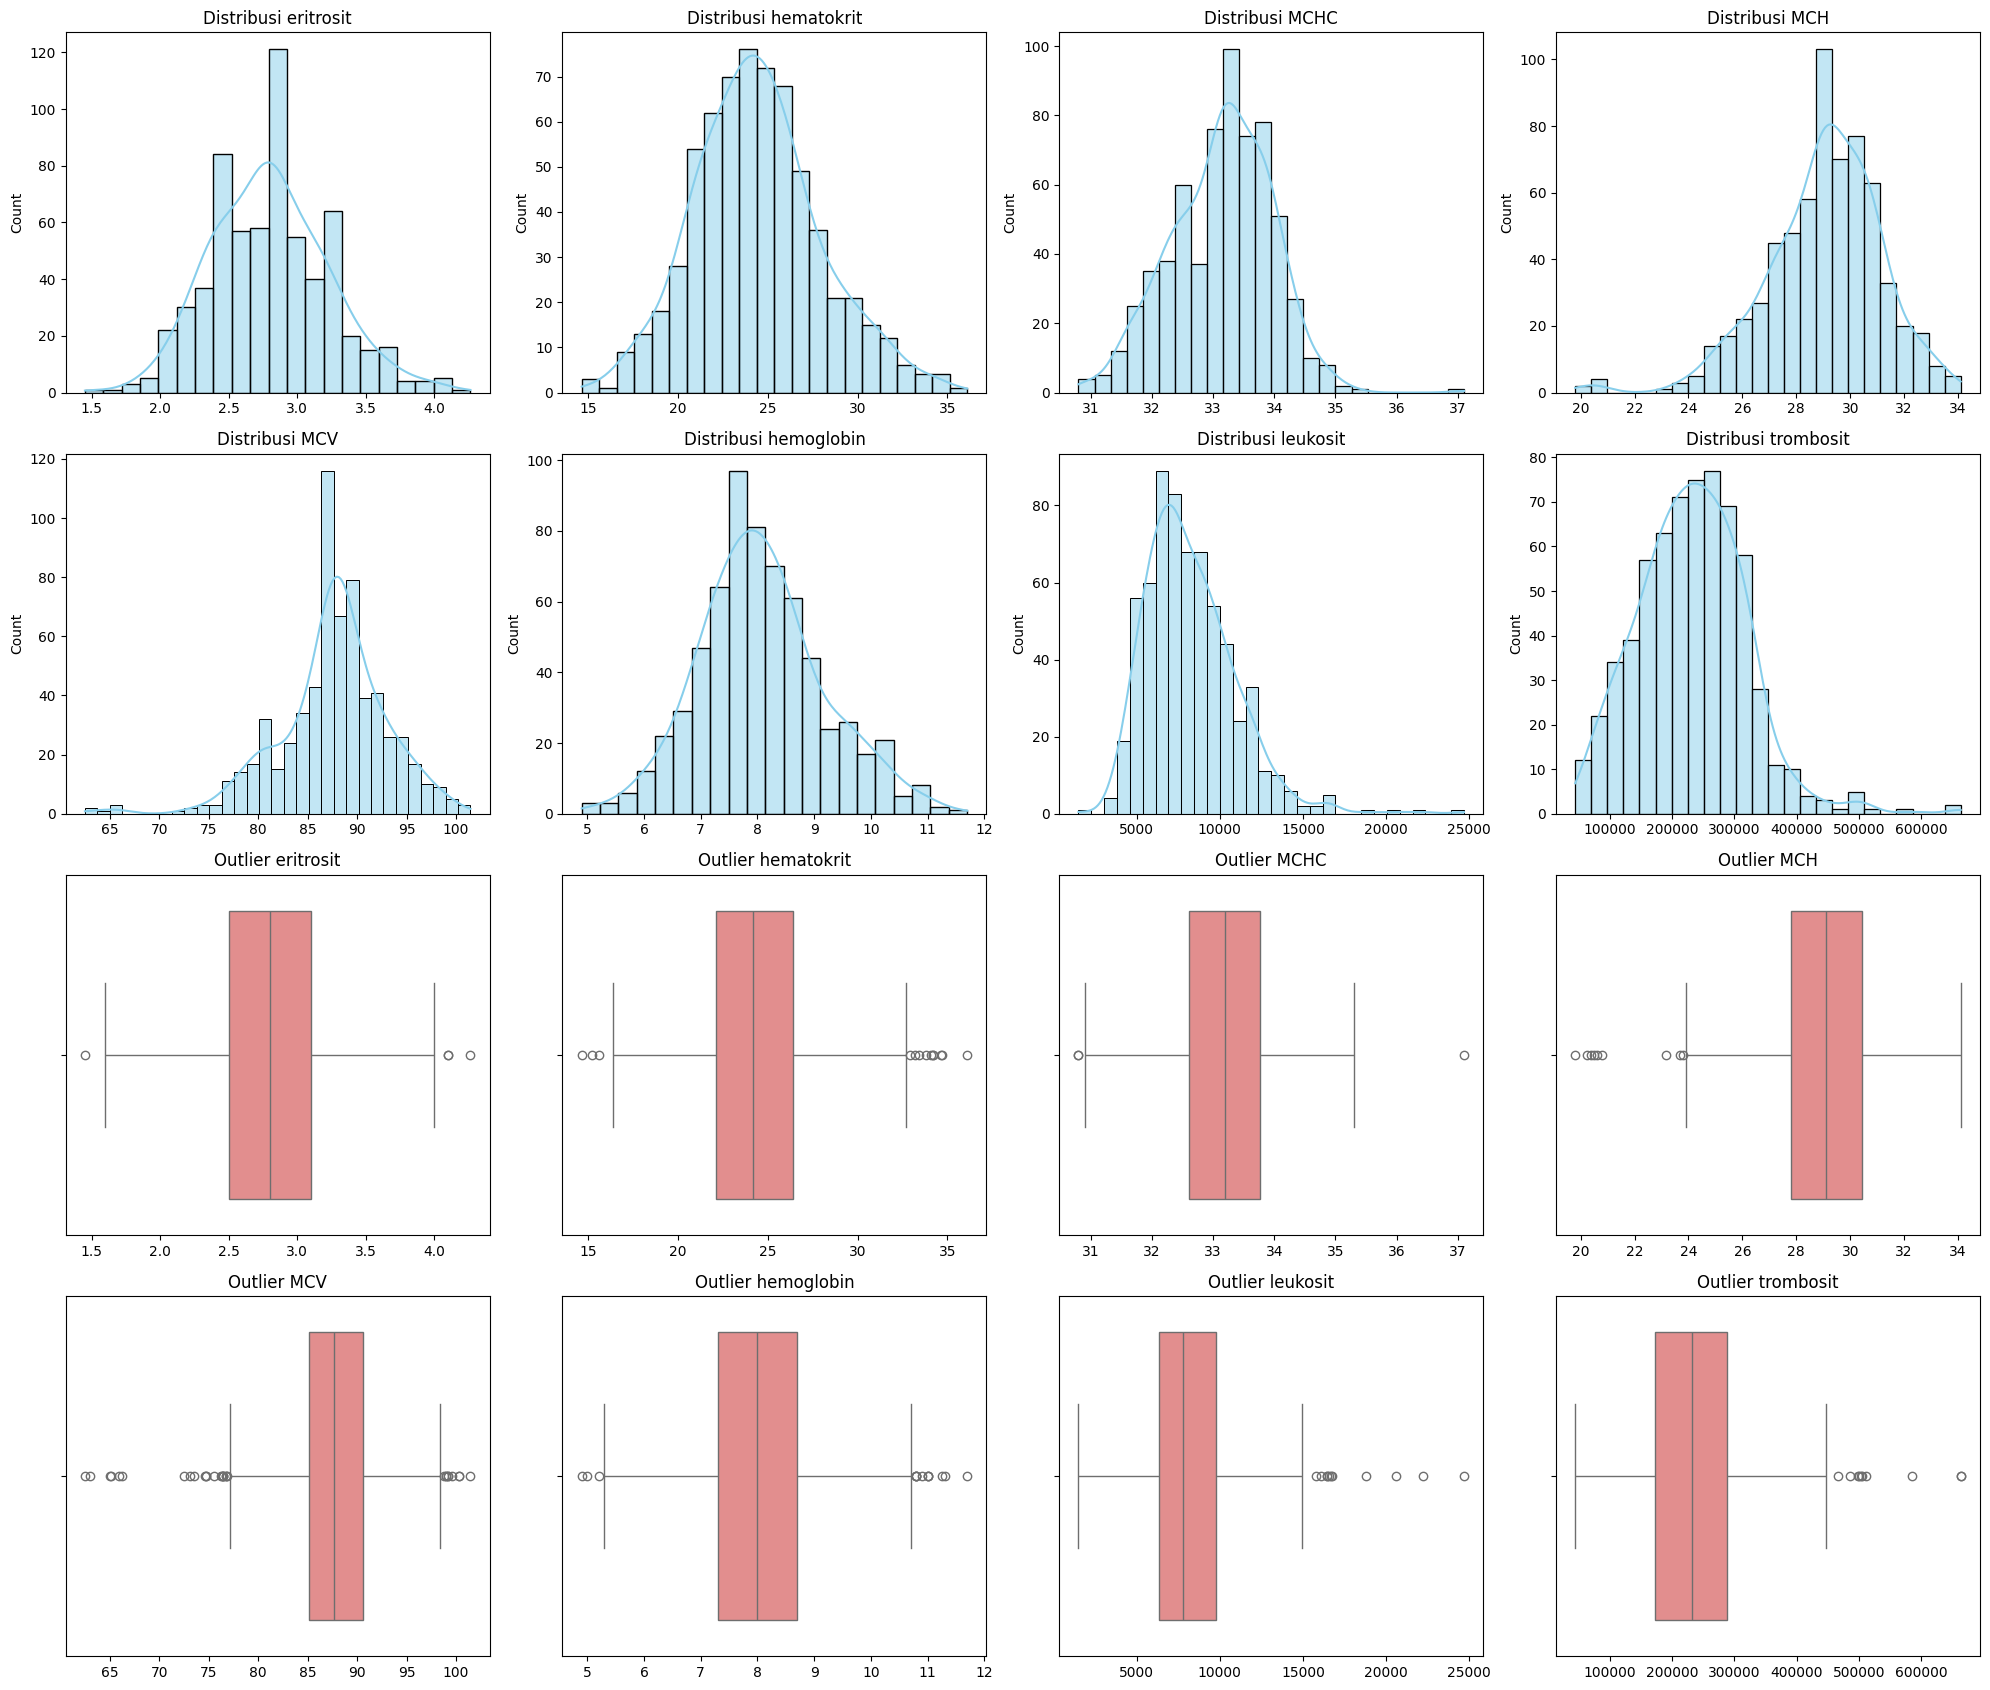

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 17))

for i, col in enumerate(cols_hematologi):
    # Histogram (Baris 1 & 2)
    plt.subplot(4, 4, i+1)
    sns.histplot(df_complete[col], kde=True, color='skyblue') # Menggunakan df_complete  
    plt.title(f'Distribusi {col}')
    plt.xlabel('')

    # Boxplot (Baris 3 & 4)
    plt.subplot(4, 4, i+9) 
    sns.boxplot(x=df_complete[col], color='lightcoral') # Menggunakan df_complete
    plt.title(f'Outlier {col}')
    plt.xlabel('')

plt.tight_layout()
plt.show()

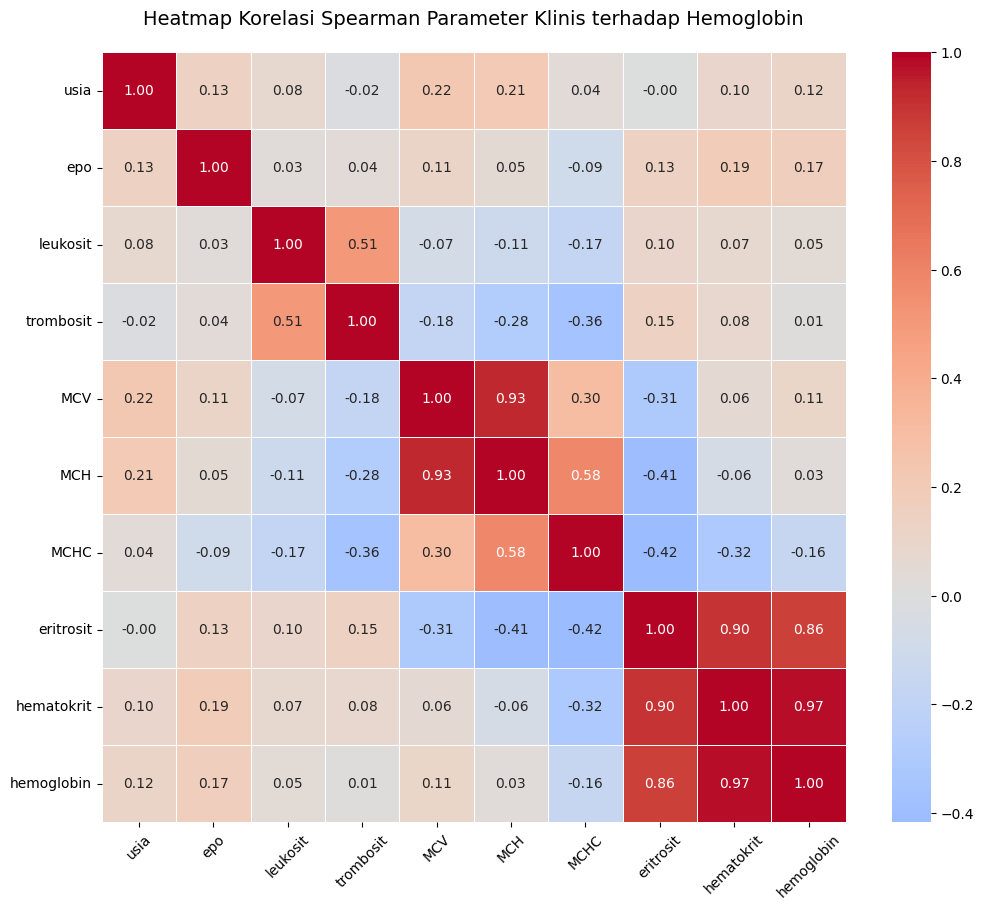

In [21]:
cols_order = ['usia', 'epo', 'leukosit', 'trombosit', 'MCV', 'MCH', 'MCHC', 'eritrosit', 'hematokrit', 'hemoglobin']

correlation_matrix = df_complete[cols_order].corr(method='spearman')

plt.figure(figsize=(12, 10))

sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5,
    center=0
)

plt.title("Heatmap Korelasi Spearman Parameter Klinis terhadap Hemoglobin", fontsize=14, pad=20)
plt.xticks(rotation=45)
plt.show()

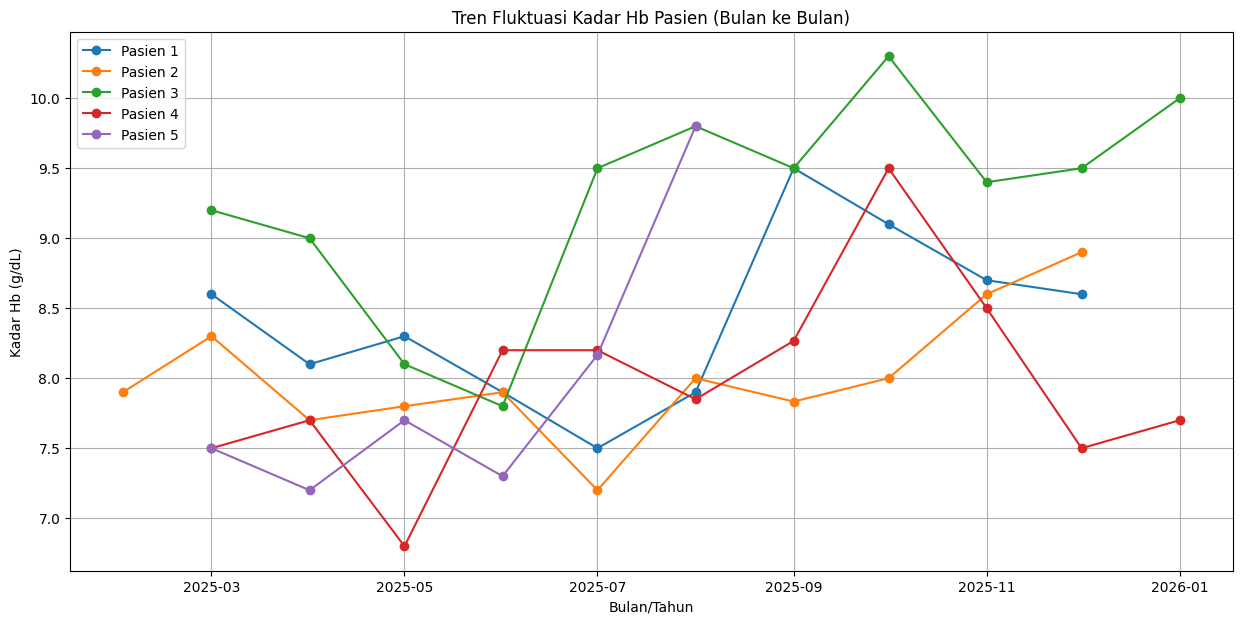

In [22]:
df_complete['tgl_pemeriksaan'] = pd.to_datetime(df_complete['tgl_pemeriksaan'])

plt.figure(figsize=(15, 7))
top_patients = df_complete['id_pasien'].unique()[:5] 
for patient in top_patients:
    patient_data = df_complete[df_complete['id_pasien'] == patient].sort_values('tgl_pemeriksaan')
    plt.plot(patient_data['tgl_pemeriksaan'], patient_data['hemoglobin'], marker='o', label=f'Pasien {patient}')

plt.title("Tren Fluktuasi Kadar Hb Pasien (Bulan ke Bulan)")
plt.xlabel("Bulan/Tahun")
plt.ylabel("Kadar Hb (g/dL)")
plt.legend()
plt.grid(True)
plt.show()